# Prediction of trial epoch with 
Jan2024
@author:Ines

In [5]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE()

## Parameters

In [6]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [7]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [8]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial phase

In [9]:
bins_df = bins_per_trial_phase(design_matrix, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:410: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:412: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:413: FutureWarning

## Auto-correlation per trial phase

In [10]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

new_df['Lick count'] = gaussian_filter1d(new_df['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
new_df['avg_wheel_vel'] = np.abs(new_df['avg_wheel_vel'])

## Labels

In [85]:
# --Remove NaNs and mouse column from design matrix

mat = new_df.drop(columns=['Bin', 'Trial', 'label'])
var = 'broader_label'
mat = mat.dropna()
mat = mat.drop_duplicates()
mat[var] = mat[var].replace(['Pre-choice', 'Choice', 'Post-choice'],
                 [1, 2, 3])

In [77]:
# Downsample
label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), len(use_mat.loc[use_mat[var]==3])]
min_freq = np.min(label_freq)
labels = [1, 2, 3]
for label in labels:
    original_index = np.array(use_mat.loc[use_mat[var]==label].reset_index()['index'])
    use_index = np.random.choice(original_index, min_freq, replace=False)
    if label == 1:
        new_mat = use_mat[use_mat.index.isin(use_index)].copy()
    else:
        new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)])

/tmp/ipykernel_16587/652799863.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)])
/tmp/ipykernel_16587/652799863.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)])


In [93]:
use_mat = mat.copy() 
# Downsample
# TODO: make this less hard-coded
label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), len(use_mat.loc[use_mat[var]==3])]
min_freq = np.min(label_freq)
labels = [1, 2, 3]
for label in labels:
    original_index = np.array(use_mat.loc[use_mat[var]==label].reset_index()['index'])
    use_index = np.random.choice(original_index, min_freq, replace=False)
    if label == 1:
        new_mat = use_mat[use_mat.index.isin(use_index)].copy()
    else:
        new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())
new_mat = new_mat.reset_index().drop(columns=['index'])



/tmp/ipykernel_16587/1925585801.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())
/tmp/ipykernel_16587/1925585801.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_mat = new_mat.append(use_mat[use_mat.index.isin(use_index)].copy())


In [102]:
labels = np.array(use_mat[var])
labels_nr = np.arange(labels.shape[0])
N_MICE = min_freq
# Randomly select N mice from each lab to equalize classes
use_index = np.empty(0, dtype=int)
for j, lab in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == lab],
                                                            N_MICE, replace=False)])

In [132]:
"""
RUN MODEL
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice

shufflings = 1000  #shuffling
model = GaussianNB()
# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

# Decoding function with 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
use_mat = mat.copy() # test using all mice

# Find minimum number of samples per label
labels = np.array(use_mat[var])
labels_nr = np.arange(labels.shape[0])
label_freq = [len(use_mat.loc[use_mat[var]==1]), len(use_mat.loc[use_mat[var]==2]), len(use_mat.loc[use_mat[var]==3])]
min_freq = np.min(label_freq)

# Randomly select N mice from each lab to equalize classes
use_index = np.empty(0, dtype=int)
for j, epoch in enumerate(np.unique(labels)):
    use_index = np.concatenate([use_index, np.random.choice(labels_nr[labels == epoch],
                                                            min_freq, replace=False)])

new_mat = use_mat.iloc[use_index].reset_index().drop(columns=['index']).copy()
        
# -- ORIGINAL DATASET

dec_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

y_pred = np.zeros(len(new_mat), dtype=int) 
exog = new_mat[new_mat.columns.difference([var])]
endog = new_mat.loc[:, var]

for train_index, test_index in kf.split(new_mat):
    model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
    y_pred[test_index] = model.predict(exog.iloc[test_index])

# Calculate f1 score and confusion matrix
f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')

# Save results
dec_result.loc[0, 'f1'] = f1
dec_result.loc[0, 'confusion_matrix'] = cm
dec_result.loc[0, 'shuffle'] = 0

decoding_result = pd.concat([decoding_result, dec_result])

# -- SHUFFLED DATASET 

shuffle_result = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix'])

for s in range(shufflings):
    if np.mod(s+1, 10) == 0:
        print('Shuffling %d of %d' % (s+1, shufflings))   

    shuffle_y_pred = np.zeros(len(new_mat), dtype=int) 
    shuffle_endog = endog.copy()
    np.random.shuffle(shuffle_endog.values)

    for train_index, test_index in kf.split(new_mat):
        model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
        shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

    shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
    shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

    # SAVE
    shuffle_result.loc[s, 'f1'] = shuffle_f1
    shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
    shuffle_result.loc[s, 'shuffle'] = s + 1

decoding_result = pd.concat([decoding_result, shuffle_result])

Shuffling 10 of 1000
Shuffling 20 of 1000
Shuffling 30 of 1000
Shuffling 40 of 1000
Shuffling 50 of 1000
Shuffling 60 of 1000
Shuffling 70 of 1000
Shuffling 80 of 1000
Shuffling 90 of 1000
Shuffling 100 of 1000
Shuffling 110 of 1000
Shuffling 120 of 1000
Shuffling 130 of 1000
Shuffling 140 of 1000
Shuffling 150 of 1000
Shuffling 160 of 1000
Shuffling 170 of 1000
Shuffling 180 of 1000
Shuffling 190 of 1000
Shuffling 200 of 1000
Shuffling 210 of 1000
Shuffling 220 of 1000
Shuffling 230 of 1000
Shuffling 240 of 1000
Shuffling 250 of 1000
Shuffling 260 of 1000
Shuffling 270 of 1000
Shuffling 280 of 1000
Shuffling 290 of 1000
Shuffling 300 of 1000
Shuffling 310 of 1000
Shuffling 320 of 1000
Shuffling 330 of 1000
Shuffling 340 of 1000
Shuffling 350 of 1000
Shuffling 360 of 1000
Shuffling 370 of 1000
Shuffling 380 of 1000
Shuffling 390 of 1000
Shuffling 400 of 1000
Shuffling 410 of 1000
Shuffling 420 of 1000
Shuffling 430 of 1000
Shuffling 440 of 1000
Shuffling 450 of 1000
Shuffling 460 of 10

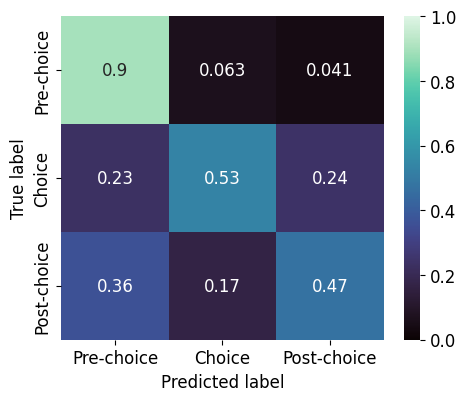

F1 results 0.6326034063260341


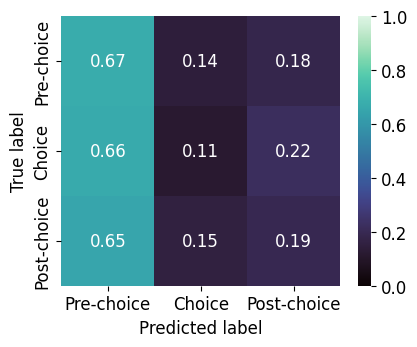

F1 shuffled results 0.32765612327656124


In [137]:
"""
PLOT RESULTS
"""

# -- Confusion Matrix
labels = np.array(mat[var])

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[5.2, 4.2])
hmap = sns.color_palette("mako", as_cmap=True)
data = decoding_result.loc[decoding_result['shuffle'] == 0]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels.astype(int)), xticklabels=np.unique(labels.astype(int)), 
    cmap= hmap, vmin=0, vmax=1) 
plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('full_cm.svg',dpi=500)
plt.show()
print('F1 results', data['f1'].mean())


# Results from shuffled model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
data = decoding_result.loc[decoding_result['shuffle'] == 1]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels), xticklabels=np.unique(labels), 
    cmap= hmap, vmin=0, vmax=1)
plt.xticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.yticks([.5, 1.5, 2.5], ['Pre-choice', 'Choice', 'Post-choice'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
print('F1 shuffled results',  data['f1'].mean())



/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 59.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 79.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


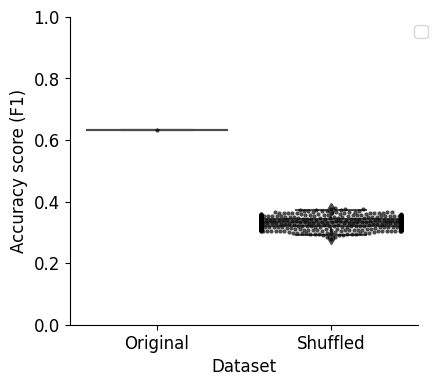

In [134]:
# -- F1 score per model, original and shuffled
data = decoding_result.copy()
data['f1'] = data['f1'].astype(float)

data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
data = data.rename(columns={'shuffle': 'Dataset'})

plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 4])
sns.boxplot(y='f1', x='Dataset', data=data, color='grey') 
sns.swarmplot(y='f1', x='Dataset', data=data, color='black', dodge=True, alpha=0.7, size=3)
plt.ylim([0,1])
plt.ylabel('Accuracy score (F1)')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(top=True, right=True)
#plt.savefig('violin.svg',dpi=500)

/opt/anaconda3/envs/learning_variability/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


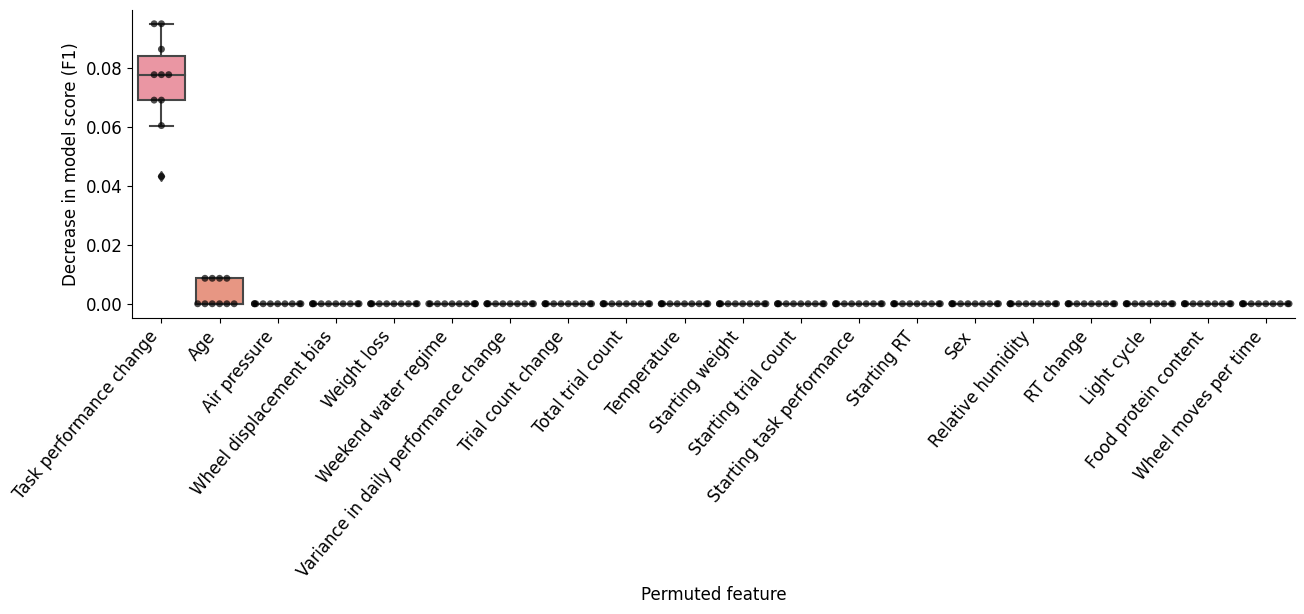

In [12]:
# -- Permutation tests for full model
f1_full_model = decoding_result.loc[(decoding_result['matrix']==0) & (decoding_result['shuffle']==0), 'f1'][0]
data = permutation_result.copy()
data['f1'] = data['f1'].astype(float)
data['f1'] = original_f1 - data['f1']
data = data.replace(['RT_delta1', 'RT_init', 'age_start', 'air_pressure_mb', 
    'delta_variance', 'disp_norm', 'moves_time',
    'perf_init', 'relative_humidity', 'sex', 
    'temperature_c', 'trials_delta1', 'trials_init', 'trials_sum', 
    'water_weight', 'weekend_water', 'weight_loss', 'light', 'food',
    'weight_start', 'perf_delta1'], ['RT change', 'Starting RT',
    'Age', 'Air pressure', 'Variance in daily performance change', 
    'Wheel displacement bias', 'Wheel moves per time',
    'Starting task performance', 'Relative humidity', 'Sex', 'Temperature', 
    'Trial count change', 'Starting trial count', 'Total trial count',
    'Consumed water per body weight', 'Weekend water regime', 
    'Weight loss', 'Light cycle', 'Food protein content',
    'Starting weight', 'Task performance change'])

plot_order = data.groupby('feature')['f1'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.boxplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v') 
sns.swarmplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v', color='black', alpha=0.7) 
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)
sns.despine(top=True, right=True)
plt.savefig('permutation_importances.svg',dpi=500)
